In [6]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import QFT
from draperqftadder_adapt import draper_adder
from math import log2

def div_1_arg(a_bits, b, b_bits):
    reg_a = QuantumRegister(a_bits, "a")

    # registrador dos 0s
    reg_0 = QuantumRegister(a_bits - b_bits + 2, "0")

    # registrador para o carryout do DraperQFTAdder
    reg_cout = QuantumRegister(1, "cout")

    circuito = QuantumCircuit(reg_0, reg_a, reg_cout)

    for i in range(a_bits - b_bits + 1):
        circuito.append(draper_adder(a_bits - i, b, div=True).inverse(), reg_a[:a_bits - i] + reg_cout[:])
        circuito.cx(reg_0[-1], reg_cout[0])
        circuito.cx(reg_cout[0], reg_0[i], ctrl_state="0")
        circuito.cx(reg_0[i], reg_0[i + 1], ctrl_state="0")
        if i > 0:
            circuito.cx(reg_a[a_bits - i], reg_0[-1])
        circuito.append(draper_adder(a_bits - i, b, controlado=True, div=True),
                        reg_0[1 + i:2 + i] + reg_a[:a_bits - i] + reg_cout[:])
        circuito.cx(reg_0[i], reg_0[i + 1], ctrl_state="0")
        if i < a_bits - b_bits:
            circuito.cx(reg_a[a_bits - i - 1], reg_0[-1])

    return circuito

def div_A_mod(a_bits, b, b_bits):
    reg_a = QuantumRegister(a_bits, "a")

    # registrador dos 0s
    reg_0 = QuantumRegister(a_bits - b_bits + 2, "0")

    # registrador para o carryout do DraperQFTAdder
    reg_cout = QuantumRegister(1, "cout")

    reg_0_mod = QuantumRegister(b_bits, "0_mod")

    circuito = QuantumCircuit(reg_0, reg_a, reg_cout, reg_0_mod)

    circuito.append(div_1_arg(a_bits, b, b_bits), reg_0[:] + reg_a[:] + reg_cout[:])

    for i in range(b_bits):
        circuito.cx(reg_a[i], reg_0_mod[i])

    circuito.append(div_1_arg(a_bits, b, b_bits).inverse(), reg_0[:] + reg_a[:] + reg_cout[:])

    return circuito

Exemplo:

In [7]:
a_bits = 6 # q=2**a_bits, tamanho da amostra

r = 8 # r, período 
r_bits = int(log2(r))+1


reg_a = QuantumRegister(a_bits, "a")
number_a = QuantumCircuit(reg_a)

#number_a.initialize(A)

# registrador dos 0s
reg_0 = QuantumRegister(a_bits - r_bits + 2, "0")

# registrador para o carryout do DraperQFTAdder
reg_cout = QuantumRegister(1, "cout")

reg_0_mod = QuantumRegister(r_bits, "0_mod")

reg_result = ClassicalRegister(a_bits, "resultado")
#reg_mod = ClassicalRegister(b_bits, "MOD")
#reg_A_result = ClassicalRegister(a_bits, "ResultadoA")

circuito = QuantumCircuit(reg_0, reg_a, reg_cout, reg_0_mod, reg_result)

for i in range(a_bits):
    circuito.h(reg_a[i])

circuito = (
    circuito.compose(number_a, qubits=reg_a)
    .compose(div_A_mod(a_bits, r, r_bits), qubits=reg_0[:] + reg_a[:] + reg_cout[:] + reg_0_mod[:])
)

circuito.append(QFT(a_bits).inverse(), reg_a)

circuito.measure(reg_a[:], reg_result)
#circuito.measure(reg_0_mod, reg_mod)
#circuito.measure(reg_a, reg_A_result)

Simulação:

H mod 8
|A>|A mod r>: {0: 131222, 48: 130690, 32: 131079, 24: 131479, 40: 131352, 16: 130821, 56: 131161, 8: 130772}


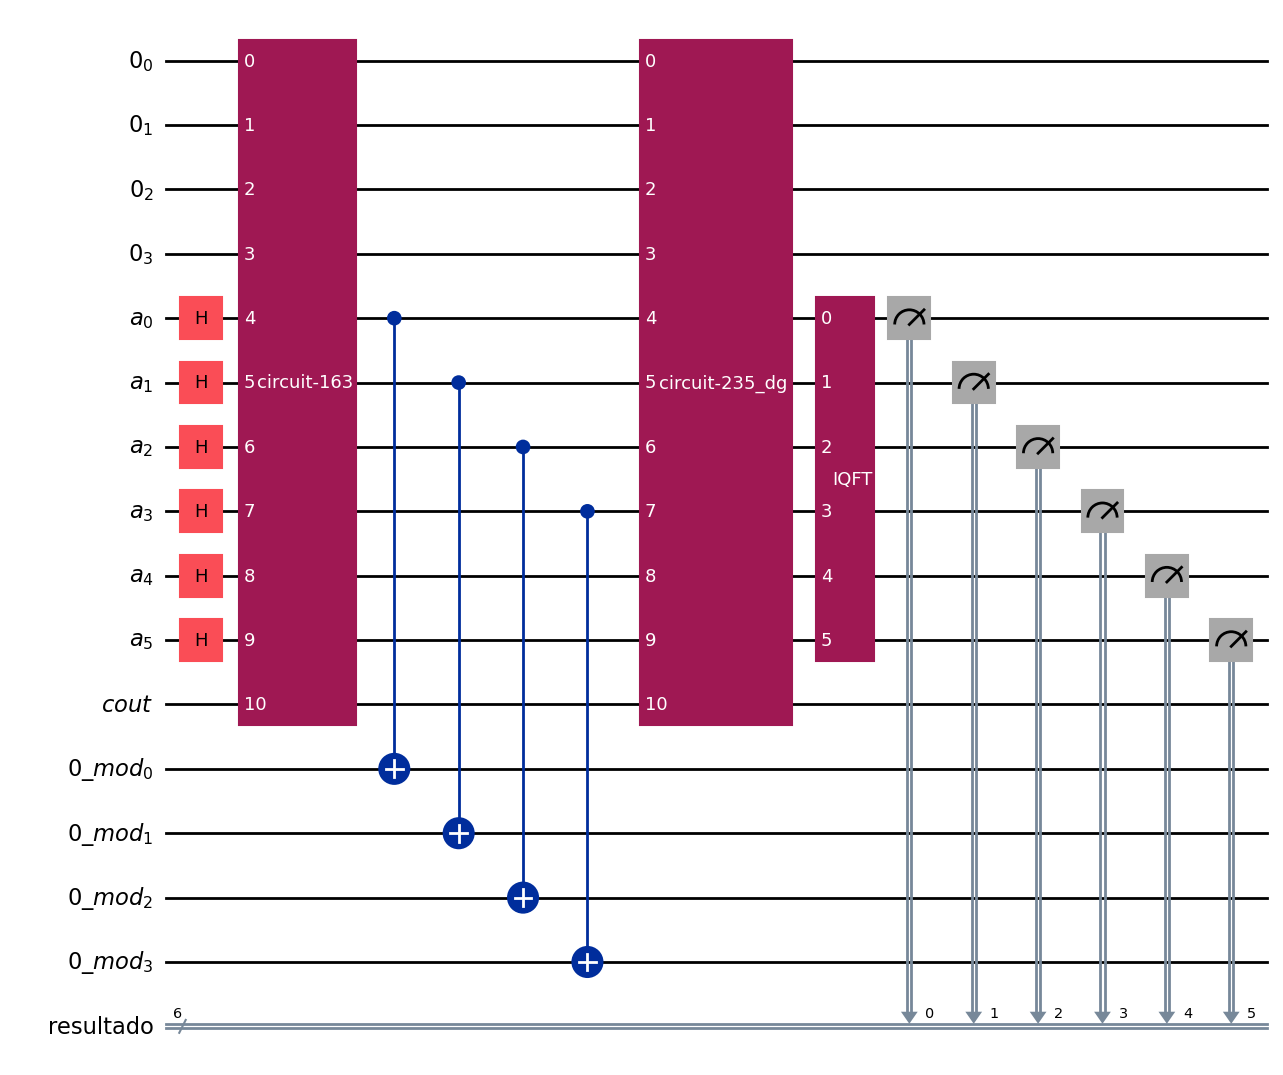

In [10]:
from qiskit_aer import AerSimulator
from qiskit import transpile

backend1 = AerSimulator(method="matrix_product_state")
qc1 = transpile(circuito, backend=backend1)

from qiskit.primitives import StatevectorSampler

statevectorsampler = StatevectorSampler()
pub = (qc1)
job = statevectorsampler.run([pub], shots=2**10)


print(f"H mod {r}")

result = job.result()[0].data.resultado.get_int_counts()

print("|A>|A mod r>:", result)
'''
for i in result:
    res=f"{i:9b}".strip()
    resA="0b0"+res[0:a_bits]
    resB="0b0"+res[a_bits:]
    print(f"{resA}({eval(resA)}),{resB}({eval(resB)})")
    #print("A:", job.result()[0].data.ResultadoA.get_int_counts())
'''
for i in range(2**a_bits):
    try:
        result[i]
    except:
        result[i] = 1

#print(circuito)
circuito.draw("mpl")

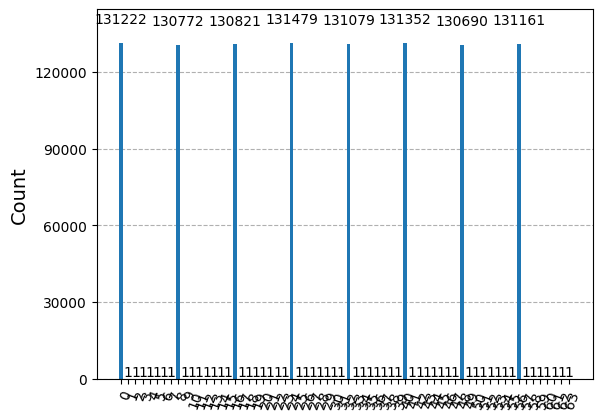

In [11]:
from qiskit.visualization import plot_histogram
plot_histogram(result)#, figsize=(15, 15))